In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
string.punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load train and test data

In [3]:
train_data = pd.read_csv("../input/nlp-getting-started/train.csv")
test_data = pd.read_csv("../input/nlp-getting-started/test.csv")

**Exploratory Data Analysis (EDA)**

Here you can see the first 5 rows of the train and test data and see the preview of the train and test dataset.

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print(train_data.shape)
print(test_data.shape)

(7613, 5)
(3263, 4)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Check nulls

In [8]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Investigate "keywords"


In [10]:
# check total number of keywords
print(len(train_data['keyword'].value_counts()))

221


In [11]:
#top 30 keywords
train_data['keyword'].value_counts()[0:30]

fatalities     45
deluge         42
armageddon     42
harm           41
sinking        41
damage         41
body%20bags    41
siren          40
outbreak       40
twister        40
evacuate       40
collided       40
fear           40
windstorm      40
derailment     39
collision      39
weapon         39
weapons        39
sunk           39
sinkhole       39
flames         39
wreckage       39
famine         39
earthquake     39
whirlwind      39
explosion      39
hellfire       39
wrecked        39
oil%20spill    38
hurricane      38
Name: keyword, dtype: int64

In [12]:
# Top 10 disaster keywords 
disaster_keyword = train_data[train_data["target"] == 1]["keyword"].value_counts()
print("Disaster keywords : ")
print(disaster_keyword[0:10])

Disaster keywords : 
outbreak             39
wreckage             39
derailment           39
debris               37
oil%20spill          37
typhoon              37
evacuated            32
rescuers             32
suicide%20bombing    32
suicide%20bomb       32
Name: keyword, dtype: int64


In [13]:
# Top 10 Non-disaster keywords 
non_disaster_keyword = train_data[train_data["target"] == 0]["keyword"].value_counts()
print("Non-Disaster keywords : ")
print(non_disaster_keyword[0:10])

Non-Disaster keywords : 
body%20bags    40
harm           37
armageddon     37
ruin           36
deluge         36
wrecked        36
fear           35
explode        35
siren          35
twister        35
Name: keyword, dtype: int64


Investigate "location"

In [14]:
#print total number of locations
print(len(train_data['location'].value_counts()))

3341


In [15]:
# top 10 locations
train_data['location'].value_counts()[0:10]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

In [16]:
# Top 10 disaster locations 
disaster_location = train_data[train_data["target"] == 1]["location"].value_counts()
print("Disaster locations : ")
print(disaster_location[0:10])

Disaster locations : 
USA               67
United States     27
Nigeria           22
India             20
Mumbai            19
New York          16
UK                16
London            16
Washington, DC    15
Canada            13
Name: location, dtype: int64


In [17]:
# Top 10 Non-disaster location 
non_disaster_location = train_data[train_data["target"] == 0]["location"].value_counts()
print("Non-Disaster locations : ")
print(non_disaster_location[0:10])

Non-Disaster locations : 
New York           55
USA                37
London             29
United States      23
Los Angeles, CA    18
Canada             16
Kenya              15
Everywhere         12
Florida            11
UK                 11
Name: location, dtype: int64


Investigate "tweet"

In [18]:
#creating a new column of each tweet length
train_data['each_tweet_len'] = train_data['text'].apply(len)

In [19]:
# print maximum and minimum length of the tweet
print("Minimum Tweet Length: ", min(train_data['each_tweet_len']))
print("Maximum Tweet Length: ", max(train_data['each_tweet_len']))

Minimum Tweet Length:  7
Maximum Tweet Length:  157


In [20]:
# preview data
train_data.head()

,id,keyword,location,text,target,each_tweet_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


Create visualizations to understand the data. 
We created bar plots to show point estimates and confidence intervals as rectangular bars. We also created histograms using histplot(), an axes-level function for plotting histograms, including with kernel density smoothing.

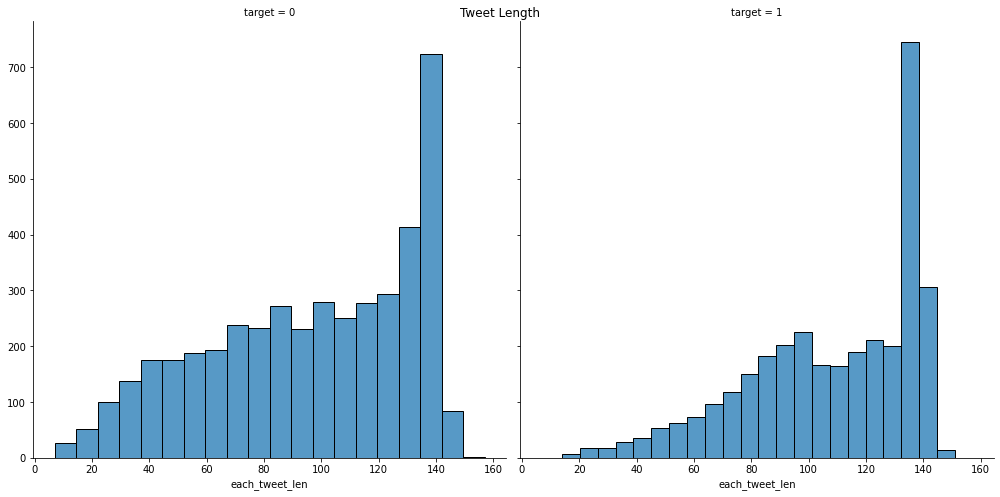

In [21]:
#visualizing tweet length
g = sns.FacetGrid(train_data, col="target", height=7)
g = g.map(sns.histplot, "each_tweet_len")
plt.suptitle("Tweet Length")
plt.show()

In [22]:
#count number of words
def word_count(x):
    return len(x.split())
    
train_data["num_words"] = train_data["text"].apply(word_count)

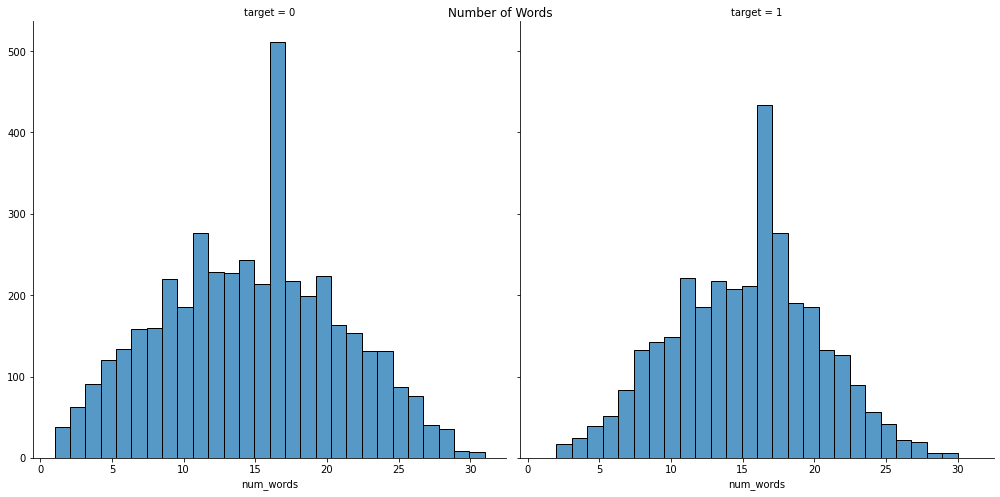

In [23]:
#visualizing the number of words
g = sns.FacetGrid(train_data, col="target", height=7)
g = g.map(sns.histplot, "num_words")
plt.suptitle("Number of Words")
plt.show()

Not Disaster:4342 , Disaster: 3271
Not Disaster:57.03% , Disaster: 42.97%


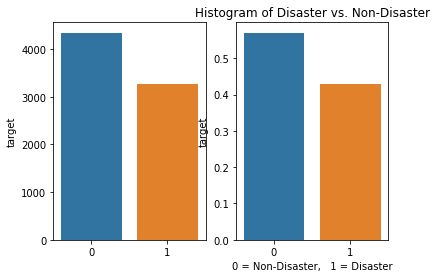

In [24]:
# created bar chart to compare tweets classified as disaster or not disaster
target_vc = train_data["target"].value_counts()
target_vc1 = train_data["target"].value_counts(normalize=True)

print("Not Disaster:{} , Disaster: {}".format(target_vc[0], target_vc[1]))
print("Not Disaster:{:.2%} , Disaster: {:.2%}".format(target_vc1[0], target_vc1[1]))

fig, axes = plt.subplots(1,2)
sns.barplot(x=target_vc.index, y=target_vc, ax=axes[0])
sns.barplot(x=target_vc1.index, y=target_vc1, ax=axes[1])
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster,   1 = Disaster")
plt.show()

Install GPUtil

In [25]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=551c8591ee3ed24ea1236238a102207820c891caffc5485a02d983a0a12bd6bf
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


**Data Preprocessing**

In [26]:
#listing all abbreviations
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

Functions to do the following:
* Remove all URLs, replace by URL
* Remove HTML beacon
* Remove non printable characters
* Change an abbreviation by its true meaning
* Replace all abbreviations
* Remove @ and mention, replace by USER
* Remove numbers, replace it by NUMBER
* Remove all emojis, replace by EMOJI
* Replace some others smileys with SADFACE
* Replace some smileys with SMILE
* Replace <3 with HEART
* Factorize elongated words, add ELONG
* Factorize repeated punctuation, add REPEAT
* Remove all punctuations
* Remove punctuations
* Remove all english stopwords

In [27]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)


# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all english stopwords
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [28]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # Lower text, replace abbreviations
    text = text.lower()
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    text = remove_all_punct(text)
    text = remove_punct(text)
    text = remove_stopwords(text)

    return text

Clean text and add a new feature

In [29]:
# Clean text and add a new feature
train_data["clean_text"] = train_data["text"].apply(clean_tweet)
test_data["clean_text"] = test_data["text"].apply(clean_tweet)

train_data["clean_tokens"] = train_data["clean_text"].apply(lambda x: tokenize(x))
test_data["clean_tokens"] = test_data["clean_text"].apply(lambda x: tokenize(x))

NameError: name 'tokenize' is not defined

In [30]:
#print clean text and the original text
train_data[['clean_text','text']].head(10)

,clean_text,text
0,deeds reason earthquake may allah forgive us,Our Deeds are the Reason of this #earthquake M...
1,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada
2,residents asked shelter place notified officer...,All residents asked to 'shelter in place' are ...
3,NUMBER people receive wildfires evacuation ord...,"13,000 people receive #wildfires evacuation or..."
4,got sent photo ruby alaska smoke wildfires pou...,Just got sent this photo from Ruby #Alaska as ...
5,rockyfire update california hwy NUMBER closed ...,#RockyFire Update => California Hwy. 20 closed...
6,flood disaster heavy rain causes flash floodin...,#flood #disaster Heavy rain causes flash flood...
7,im top hill see fire woods REPEAT,I'm on top of the hill and I can see a fire in...
8,theres emergency evacuation happening building...,There's an emergency evacuation happening now ...
9,im afraid tornado coming area REPEAT,I'm afraid that the tornado is coming to our a...


In [31]:
#preview changes made for train_data
train_data.head()

,id,keyword,location,text,target,each_tweet_len,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,got sent photo ruby alaska smoke wildfires pou...


**Vectorization**

Import libraries and set random seed. Use the seed() method to customize the start number of the random number generator.

In [32]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import f1_score 
import random
random.seed = 123

We used count vectorizer to convert a collection of text documents to a matrix of token counts. Also, we used Tfit vectorizer to convert a collection of raw documents to a matrix of TF-IDF features. We are vectorizing the train and test data. 

In [33]:
max_features=5000

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)
sparce_matrix_train=count_vectorizer.fit_transform(train_data['clean_text'])
sparce_matrix_test=count_vectorizer.fit_transform(train_data['clean_text'])

def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect, count_vectorizer

def tfidf_vector(data):
    tfidf_vectorizer = TfidfVectorizer()
    vect = tfidf_vectorizer.fit_transform(data)
    return vect, tfidf_vectorizer

X_train_count, count_vectorizer = count_vector(train_data['clean_text'])
X_train_tfidf, tfidf_vectorizer = tfidf_vector(train_data['clean_text'])

X_test_count = count_vectorizer.transform(test_data['clean_text'])                                                     
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_text'])

import pickle    

with open('count_vectorizer.pickle', 'wb') as handle:
    pickle.dump(count_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tfidf_vectorizer.pickle', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


**Create different models to compare results**

* LogisticRegression
* SVC
* MultinomialNB
* DecisionTreeClassifier
* KNeighborsClassifier
* RandomForestClassifier

In [34]:
# create a data frame with 'model' ,'vectoriser', 'f1 score', 'train accuracy','test accuracy'
metrics = pd.DataFrame(columns=['model' ,'vectoriser', 'f1 score', 'train accuracy','test accuracy'])

In [35]:
#dumping the pickled count and tfidf vectorizer
from joblib import dump

def fit_and_predict(model,x_train,x_test,y_train,y_test,vectoriser):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)

    #fit training data
    classifier.fit(x_train,y_train)
    filename = classifier_name +" using "+ str(vectoriser)+".joblib"
    filename = filename.lower().replace(" ","_")
    dump(model, filename=filename)
    y_pred = classifier.predict(x_test)
    
    #plot confusion matrix
    cmatrix = confusion_matrix(y_test,y_pred)
    
    f,ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmatrix,annot=True,linewidths=0.5,cbar=False,linecolor="red",fmt='.0f',ax=ax)
    plt.xlabel("y_predict")
    plt.ylabel("y_true")
    ax.set(title=str(classifier))
    plt.show()


    # calculate f1score and accuracy
    f1score = f1_score(y_test,y_pred,average='weighted')
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    #append values to existing dataframe
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                              'vectoriser': str(vectoriser),
                             },
                               ignore_index=True
                            )
    #print classifier name with vectorizer
    print(str(classifier.__class__.__name__) +" using "+ str(vectoriser))
    # print classification report
    print(classification_report(y_test,y_pred)) 
    #print predictions
    print("y_pred " , y_pred)   
    # print training accuracy
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    # print testing accuracy
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))


Assign the random state. A random_state parameter may be provided to control the random number generator used. Next, create the list of models.

In [36]:
random_state = 123
models=[
        XGBClassifier(max_depth=6, n_estimators=1000,random_state=random_state),
        LogisticRegression(random_state=random_state),
        MultinomialNB(),
        SVC(random_state=random_state),
        DecisionTreeClassifier(random_state = random_state),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=random_state),
      ]
      

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:22:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


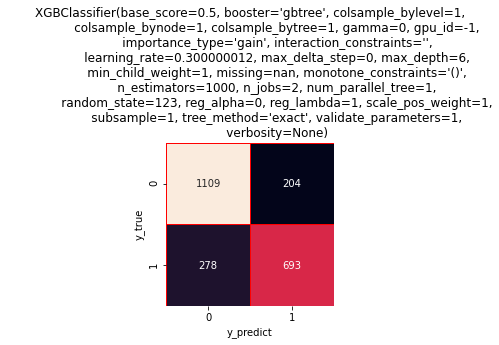

XGBClassifier using Count vector
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1313
           1       0.77      0.71      0.74       971

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:94%
Accuracy of classifier on test set:79%
[04:22:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


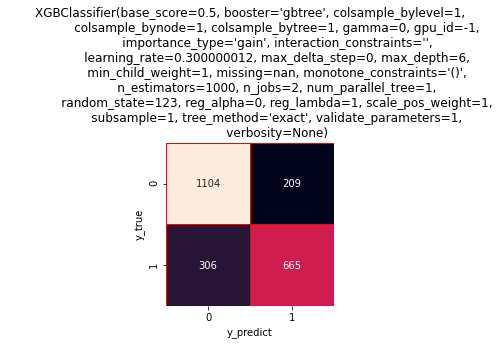

XGBClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1313
           1       0.76      0.68      0.72       971

    accuracy                           0.77      2284
   macro avg       0.77      0.76      0.77      2284
weighted avg       0.77      0.77      0.77      2284

y_pred  [0 0 0 ... 1 0 0]
Accuracy of classifier on training set:98%
Accuracy of classifier on test set:77%


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


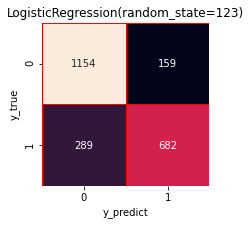

LogisticRegression using Count vector
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1313
           1       0.81      0.70      0.75       971

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.80      0.80      0.80      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:96%
Accuracy of classifier on test set:80%


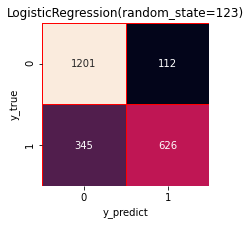

LogisticRegression using Tfidf vector
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1313
           1       0.85      0.64      0.73       971

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.81      0.80      0.79      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:89%
Accuracy of classifier on test set:80%


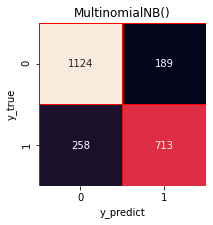

MultinomialNB using Count vector
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1313
           1       0.79      0.73      0.76       971

    accuracy                           0.80      2284
   macro avg       0.80      0.80      0.80      2284
weighted avg       0.80      0.80      0.80      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:91%
Accuracy of classifier on test set:80%


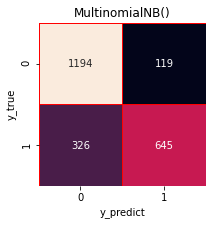

MultinomialNB using Tfidf vector
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1313
           1       0.84      0.66      0.74       971

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.81      0.80      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:90%
Accuracy of classifier on test set:81%


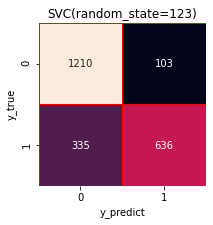

SVC using Count vector
              precision    recall  f1-score   support

           0       0.78      0.92      0.85      1313
           1       0.86      0.65      0.74       971

    accuracy                           0.81      2284
   macro avg       0.82      0.79      0.80      2284
weighted avg       0.82      0.81      0.80      2284

y_pred  [0 0 0 ... 1 0 0]
Accuracy of classifier on training set:94%
Accuracy of classifier on test set:81%


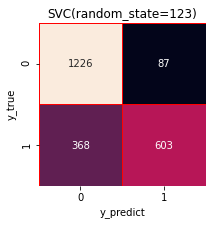

SVC using Tfidf vector
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1313
           1       0.87      0.62      0.73       971

    accuracy                           0.80      2284
   macro avg       0.82      0.78      0.78      2284
weighted avg       0.81      0.80      0.79      2284

y_pred  [0 0 0 ... 1 0 0]
Accuracy of classifier on training set:97%
Accuracy of classifier on test set:80%


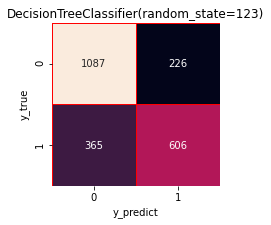

DecisionTreeClassifier using Count vector
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1313
           1       0.73      0.62      0.67       971

    accuracy                           0.74      2284
   macro avg       0.74      0.73      0.73      2284
weighted avg       0.74      0.74      0.74      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:74%


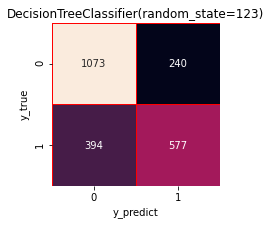

DecisionTreeClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1313
           1       0.71      0.59      0.65       971

    accuracy                           0.72      2284
   macro avg       0.72      0.71      0.71      2284
weighted avg       0.72      0.72      0.72      2284

y_pred  [0 0 1 ... 0 0 0]
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:72%


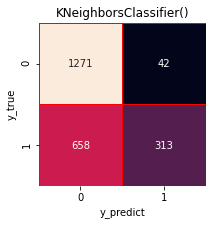

KNeighborsClassifier using Count vector
              precision    recall  f1-score   support

           0       0.66      0.97      0.78      1313
           1       0.88      0.32      0.47       971

    accuracy                           0.69      2284
   macro avg       0.77      0.65      0.63      2284
weighted avg       0.75      0.69      0.65      2284

y_pred  [0 0 0 ... 0 0 0]
Accuracy of classifier on training set:75%
Accuracy of classifier on test set:69%


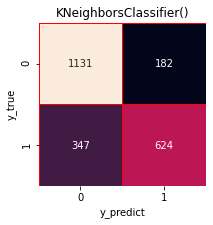

KNeighborsClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1313
           1       0.77      0.64      0.70       971

    accuracy                           0.77      2284
   macro avg       0.77      0.75      0.76      2284
weighted avg       0.77      0.77      0.76      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:83%
Accuracy of classifier on test set:77%


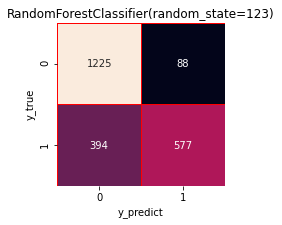

RandomForestClassifier using Count vector
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1313
           1       0.87      0.59      0.71       971

    accuracy                           0.79      2284
   macro avg       0.81      0.76      0.77      2284
weighted avg       0.80      0.79      0.78      2284

y_pred  [0 0 0 ... 0 0 0]
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:79%


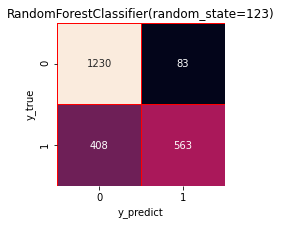

RandomForestClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      1313
           1       0.87      0.58      0.70       971

    accuracy                           0.79      2284
   macro avg       0.81      0.76      0.76      2284
weighted avg       0.80      0.79      0.78      2284

y_pred  [0 0 0 ... 0 0 0]
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:79%


In [37]:
# for each model, use both vectorizers (count and tfidf) to fit and predict.
for model in models:
    y = train_data.target

    x = X_train_count
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state =random_state)
    fit_and_predict(model,x_train,x_test,y_train,y_test,'Count vector')
    
    x = X_train_tfidf
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=random_state)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'Tfidf vector')


Sort metrics data frame and print it in decending order. 

In [38]:
metrics = metrics.sort_values('f1 score',ascending=False)

In [39]:
metrics

,model,vectoriser,f1 score,train accuracy,test accuracy
4,MultinomialNB,Count vector,0.803191,91,80
6,SVC,Count vector,0.803006,94,81
2,LogisticRegression,Count vector,0.801443,96,80
5,MultinomialNB,Tfidf vector,0.800662,90,81
3,LogisticRegression,Tfidf vector,0.794426,89,80
7,SVC,Tfidf vector,0.793565,97,80
0,XGBClassifier,Count vector,0.787679,94,79
12,RandomForestClassifier,Count vector,0.780243,99,79
13,RandomForestClassifier,Tfidf vector,0.775260,99,79
1,XGBClassifier,Tfidf vector,0.772607,98,77


**Analysing the best model based on F1 score**

Multinomial Naive Bayes with count vector results in the best f1score. We used Multinomial Naive Bayes with count vector to create the submittion file.

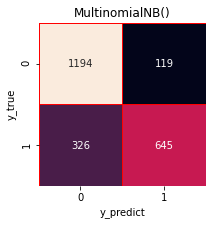

MultinomialNB using count vector
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1313
           1       0.84      0.66      0.74       971

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.81      0.80      2284

y_pred  [1 0 0 ... 1 0 0]
Accuracy of classifier on training set:90%
Accuracy of classifier on test set:81%


In [40]:
y = train_data.target
x = X_train_tfidf
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=random_state)
model = MultinomialNB()
fit_and_predict(model,x_train,x_test,y_train,y_test, 'count vector')
y_pred = model.predict(X_test_count)

In [41]:
y_pred = y_pred.round().astype(int)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

Create submission file

In [42]:
sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

sub['target'] = y_pred
sub.to_csv('submission_1.csv', index=False)